In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
minist = input_data.read_data_sets("../03-Convolutional-Neural-Networks/MNIST_data/",one_hot=True)

Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../03-Convolutional-Neural-Networks/MNIST_data/t10k-labels-idx1-ubyte.gz


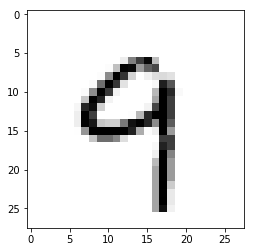

In [6]:
plt.imshow(minist.train.images[8].reshape(28,28),cmap='Greys')

# Variable scope

     variable scpope allow to have modular sections or subsets of parameter so those belonging to certatin layers that way when an architechure of layer is repeated. so when you call thisgenerator function again the same name s of those those variable can be used within each layer scope.

In [7]:
def generator(z,reuse=None): # z is the random noise that we start the generator with
    with tf.variable_scope('gen',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units= 128)
        
        #for leaky relu because in tensorflow 1.3 it not included but 1.4 and 1.5 are included leaky relu so we create our own leaky relu 
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs = hidden1,units = 128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        output = tf.layers.dense(inputs=hidden2,units=784,activation=tf.nn.tanh)
        
        return output

In [8]:
def descriminator(X,reuse=None): # X is the actual data
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units= 128)
        
        #for leaky relu because in tensorflow 1.3 it not included but 1.4 and 1.5 are included leaky relu so we create our own leaky relu 
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1,hidden1)
        
        hidden2 = tf.layers.dense(inputs = hidden1,units = 128)
        
        hidden2 = tf.maximum(alpha*hidden2,hidden2)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
        
        return output,logits
        

# Placeholder

In [9]:
realimage = tf.placeholder(tf.float32,shape = [None,784]) # None for batch size that we later define and 784 is multiplication of 28*28 pixles
z = tf.placeholder(tf.float32,shape = [None,100]) # 100 because we want to generate 100 data points

In [10]:
G = generator(z)

In [11]:
D_output_real , D_logits_real = descriminator(realimage)

In [12]:
D_output_fake , D_logits_fake = descriminator(G,reuse = True) # reuse = True beacause we use the descriminator twise so if we don't use variable scpe we get error

# Losses

In [13]:
def loss_func(logits_in,lables_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = lables_in, logits = logits_in))

In [14]:
D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real) *0.9)
D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))
# ,tf.ones_like(D_logits_real) with this we declare all the real lables are set 1  or say true
# ,tf.zeros_like(D_logits_real) with tis we decalare all the fake lables are 0 or false
# tf.one() take several parameter and tf.ones_like only take shpae so we take tf.ones_like

#to make descriminator generalize we apply smoothing,so this hepls descriminator generalize better. it basically maeans that we reduce the lable a bit from being perfect from
#1.0 to being smothing 0.9 so we do *0.9 to apply smoothing factor

In [15]:
D_loss = D_real_loss + D_fake_loss

In [16]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [17]:
learning_rate = 0.001

In [18]:
tvars = tf.trainable_variables() # Returns all variables created with `trainable=True`., function returns the contents of that collection.

d_vars = [var for var in tvars if 'dis' in var.name] # for every variable in trainable variable dis(descriminator) in it's name. 
g_vars = [var for var in tvars if 'gen' in var.name]


# Optimizer

In [19]:
D_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=d_vars)

In [20]:
G_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=g_vars)

In [21]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

# Training

In [22]:
batch_size = 100

In [23]:
epochs = 30

In [24]:
init = tf.global_variables_initializer()

In [25]:
samples = []

In [26]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for e in range(epochs):
        
        num_batches = minist.train.num_examples // batch_size # gives the whole number.  // indicates classic division
        
        for i in range(num_batches):
            batch = minist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale to pass to D
            batch_images = batch[0].reshape((batch_size, 784)) # reacaling the images to fit in to network
            batch_images = batch_images *2 - 1 # for linear transoformation for tanh
            
            # Z (random latent noise data for Generator)
            # -1 to 1 because of tanh activation
            batch_z = np.random.uniform(-1,1,size=(batch_size,100))
            
            _ = sess.run(D_trainer,feed_dict={realimage:batch_images, z:batch_z}) # _ = because we don't want to store the result we just want to run it
            _ = sess.run(G_trainer,feed_dict={z:batch_z})
            
        print("Currently on Epoch {} of {} total...".format(e+1, epochs))
        
        sample_z = np.random.uniform(-1,1,size=(1,100)) # in size=(1,100) 1 for we want 1 sample and 100 is our batch_size
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        samples.append(gen_sample)
        
        

Currently on Epoch 1 of 30 total...
Currently on Epoch 2 of 30 total...
Currently on Epoch 3 of 30 total...
Currently on Epoch 4 of 30 total...
Currently on Epoch 5 of 30 total...
Currently on Epoch 6 of 30 total...
Currently on Epoch 7 of 30 total...
Currently on Epoch 8 of 30 total...
Currently on Epoch 9 of 30 total...
Currently on Epoch 10 of 30 total...
Currently on Epoch 11 of 30 total...
Currently on Epoch 12 of 30 total...
Currently on Epoch 13 of 30 total...
Currently on Epoch 14 of 30 total...
Currently on Epoch 15 of 30 total...
Currently on Epoch 16 of 30 total...
Currently on Epoch 17 of 30 total...
Currently on Epoch 18 of 30 total...
Currently on Epoch 19 of 30 total...
Currently on Epoch 20 of 30 total...
Currently on Epoch 21 of 30 total...
Currently on Epoch 22 of 30 total...
Currently on Epoch 23 of 30 total...
Currently on Epoch 24 of 30 total...
Currently on Epoch 25 of 30 total...
Currently on Epoch 26 of 30 total...
Currently on Epoch 27 of 30 total...
Currently 

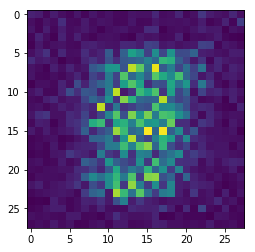

In [27]:
plt.imshow(samples[3].reshape(28,28))

In [ ]:
# Run the 500 epoch train model

In [ ]:
saver = tf.train.Saver(var_list=g_vars)

new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess,'06-Generative-Adversarial-Networks/models/500_epoch_model.ckpt')
    
    for x in range(5):
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from 06-Generative-Adversarial-Networks/models/500_epoch_model.ckpt


In [ ]:
plt.imshow(new_samples[3].reshape(28,28))